## End to End pet-проект: прогноз дефолта по кредиту (Credit Risk Dataset)

### План работ
1. Данные: загрузка, проверка качества, разбиение train val test
2. Baseline: простая модель и базовые метрики
3. Пайплайн: единый препроцессинг и обучение без утечек
4. Улучшение модели, настройка и сравнение
5. Интерпретация: важность признаков и простые выводы
6. Артефакты: сохранение модели и препроцессинга
7. API: FastAPI
8. Хранилище: запись запросов и предсказаний в Postgres
9. Мини интерфейс: простая форма для ввода и ответа модели

Цель: собрать воспроизводимый пайплайн от данных до API и демонстрации результата.

### 1) Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
from typing import Optional, List
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score, precision_score, recall_score, f1_score, accuracy_score 
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import json

/Users/rodion/VsCodeProjects/Trening/trening/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "laotse/credit-risk-dataset",
    "credit_risk_dataset.csv"
)
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Посмотрим на базовые данные про полученный data

In [3]:
size = data.shape
nans = data.isna().sum()

print(f'Размер: {size}; Колличество пропусков: {nans}')

Размер: (32581, 12); Колличество пропусков: person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [4]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

<Axes: ylabel='Frequency'>

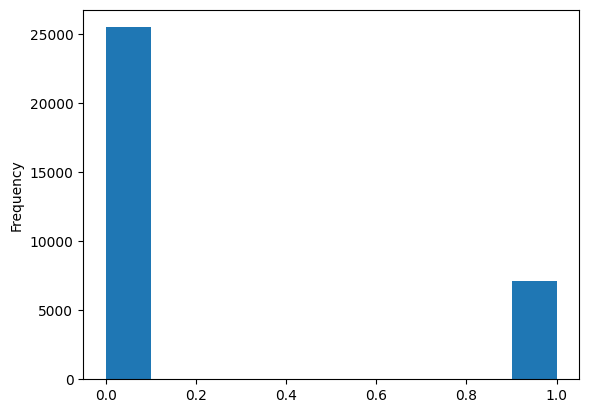

In [5]:
data['loan_status'].plot(kind = 'hist')

### Таргет находится в колонке loan_status

- Соотношение доли обьектов классов ~ 78 к 22 (присутсвует дисбаланс классов)

In [6]:
loan_zero_and_one = data['loan_status'].value_counts()
loan_percent = data['loan_status'].value_counts(normalize = True)
mean = data['loan_status'].mean()
print(
    f'Колличество таргетов 0/1: {loan_zero_and_one}; \
    Отношение колличества обьектов 0/1: {loan_percent}; \
    Итоговая доля дефолта: {mean}'
)

Колличество таргетов 0/1: loan_status
0    25473
1     7108
Name: count, dtype: int64;     Отношение колличества обьектов 0/1: loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64;     Итоговая доля дефолта: 0.21816396059052823


### Найдем долю пропусков в столбцах имеющих их(как с ними поступить решим далее)
1) person_emp_length 
2) loan_int_rate

In [7]:
person_emp = data['person_emp_length']
loan_rate = data['loan_int_rate']

diff_person = person_emp.isna().sum() / len(person_emp)
diff_rate = loan_rate.isna().sum() / len(loan_rate)

print(
    f'Доля пропусков в первом столбце: {diff_person}; \
    Доля пропусков в втором столбце: {diff_rate}'
)

Доля пропусков в первом столбце: 0.027469997851508547;     Доля пропусков в втором столбце: 0.0956385623522912


### Первичный аудит данных

Цель: перед обучением моделей понять качество данных и выявить места, где нужны правила обработки.

Проверяю:
- константные столбцы
- числовые признаки: квантили и максимумы, чтобы найти кандидатов на выбросы
- категориальные признаки: число уникальных значений и частоты категорий


In [8]:
target = "loan_status"

nunique_all = data.nunique(dropna=False)
const_cols = nunique_all[nunique_all == 1].index.tolist()
print("не константные столбцы:")
print(nunique_all)

не константные столбцы:
person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               37
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  349
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64


In [9]:
nums_rows = []
num_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
for col in num_cols:
    s = data[col]
    nums_rows.append([
        col,
        float(s.quantile(0.50)),
        float(s.quantile(0.95)),
        float(s.quantile(0.99)),
        float(s.max())
    ])

num_audit = pd.DataFrame(
    nums_rows,
    columns=["столбец", "q50", "q95", "q99", "макс."]
).sort_values("макс.", ascending=False)

print("Аудит числовых признаков:")
display(num_audit)

Аудит числовых признаков:


,столбец,q50,q95,q99,макс.
1,person_income,55000.00,138000.00,225200.00,6000000.00
3,loan_amnt,8000.00,24000.00,29800.00,35000.00
0,person_age,26.00,40.00,50.00,144.00
2,person_emp_length,4.00,13.00,18.00,123.00
7,cb_person_cred_hist_length,4.00,14.00,17.00,30.00
4,loan_int_rate,10.99,16.32,18.62,23.22
5,loan_status,0.00,1.00,1.00,1.00
6,loan_percent_income,0.15,0.38,0.50,0.83


In [10]:
suspects = num_audit[num_audit["макс."] > num_audit["q99"] * 3].copy()

print("выбросы = макс. > 3 * q99:")

display(suspects[["столбец", "q99", "макс."]])
top_cols = suspects["столбец"].head(3).tolist()
for col in top_cols:
    print(f"Экстремальные значения: {col}")
    display(data.sort_values(col, ascending=False)[[col, target]].head(10))

выбросы = макс. > 3 * q99:


,столбец,q99,макс.
1,person_income,225200.0,6000000.0
2,person_emp_length,18.0,123.0


Экстремальные значения: person_income


,person_income,loan_status
32297,6000000,0
30049,2039784,0
32546,1900000,0
32497,1782000,0
31924,1440000,0
31922,1362000,0
17833,1200000,0
29120,1200000,0
29119,1200000,0
17834,948000,0


Экстремальные значения: person_emp_length


,person_emp_length,loan_status
0,123.0,1
210,123.0,0
32355,41.0,0
32515,38.0,0
32428,34.0,1
31866,31.0,0
32263,31.0,0
31867,31.0,0
30914,31.0,0
32562,30.0,0


In [11]:
object_cols = data.select_dtypes(include=["object"]).columns.tolist()

object_rows = []
for col in object_cols:
    object_rows.append([
        col,
        int(data[col].nunique(dropna=False))
    ])

cat_audit = pd.DataFrame(
    object_rows,
    columns=["столбец", "колличество уникальных"]
).sort_values("колличество уникальных", ascending=False)

print("Аудит категориальных признаков:")
display(cat_audit)

print("Топ категорий по каждому категориальному столбцу:")
for col in object_cols:
    print(f"Столбец: {col}")
    display(data[col].value_counts(dropna=False).head(10).to_frame("количество"))


Аудит категориальных признаков:


,столбец,колличество уникальных
2,loan_grade,7
1,loan_intent,6
0,person_home_ownership,4
3,cb_person_default_on_file,2


Топ категорий по каждому категориальному столбцу:
Столбец: person_home_ownership


,количество
person_home_ownership,
RENT,16446
MORTGAGE,13444
OWN,2584
OTHER,107


Столбец: loan_intent


,количество
loan_intent,
EDUCATION,6453
MEDICAL,6071
VENTURE,5719
PERSONAL,5521
DEBTCONSOLIDATION,5212
HOMEIMPROVEMENT,3605


Столбец: loan_grade


,количество
loan_grade,
A,10777
B,10451
C,6458
D,3626
E,964
F,241
G,64


Столбец: cb_person_default_on_file


,количество
cb_person_default_on_file,
N,26836
Y,5745


In [34]:
age_col = "person_age"
emp_col = "person_emp_length"

age_max = 100
emp_max = 60

data_clean = data.copy()

mask_age = data_clean[age_col] <= age_max
mask_emp = data_clean[emp_col].isna() | (data_clean[emp_col] <= emp_max)

before_shape = data_clean.shape
data_clean = data_clean[mask_age & mask_emp].copy()
after_shape = data_clean.shape

print("Размер до удаления выбросов:", before_shape)
print("Размер после удаления выбросов:", after_shape)
print("Удалено строк:", before_shape[0] - after_shape[0])

data = data_clean


Размер до удаления выбросов: (32574, 12)
Размер после удаления выбросов: (32574, 12)
Удалено строк: 0


#### Разделим данные на выборки и проверим доли тергетов в выборках


In [13]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("loan_status")],
    np.array(data['loan_status']),
    test_size = test_size,
    random_state = 1,
    stratify = data['loan_status']
)

In [14]:
X_test


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10950,23,70000,MORTGAGE,4.0,VENTURE,C,6000,13.16,0.09,N,4
29359,37,58000,RENT,9.0,MEDICAL,B,18200,10.99,0.31,N,11
29746,39,119000,RENT,2.0,EDUCATION,A,10800,7.49,0.09,N,13
26917,32,119000,MORTGAGE,12.0,PERSONAL,B,18000,10.99,0.15,N,7
15787,25,86000,RENT,9.0,EDUCATION,D,16000,16.29,0.19,Y,2
...,...,...,...,...,...,...,...,...,...,...,...
10914,25,70000,MORTGAGE,9.0,DEBTCONSOLIDATION,B,14000,10.25,0.20,N,4
24657,32,62000,RENT,8.0,VENTURE,D,10000,17.27,0.16,Y,7
27116,28,123504,MORTGAGE,12.0,VENTURE,B,18000,NaN,0.15,N,7
5612,23,80000,RENT,6.0,PERSONAL,A,5000,5.42,0.06,N,2


In [35]:
print(
    f'Доля таргетов в Train: {Y_train.mean()}; \
    Доля таргетов в Test: {Y_test.mean()}'
)

Доля таргетов в Train: 0.2181971679650025;     Доля таргетов в Test: 0.21811204911742132


## 2) Baseline

- Метрики: ROC-AUC и PR-AUC 
- Базовая модель: логистическая регрессия
- Оценка качества: Stratified K-Fold
- Препроцессинг в пайплайне: 
  - числовые признаки: заполнение пропусков медианой
  - категориальные признаки: one-hot кодирование
  - нормализация признаков через StandardScaler, иначе из за разных масштабов не сойдется градиентный алгоритм
- Цель: получить точку отсчета

### Преобразование

- колонки с пропусками заменим медианой
- колонки с категорильными признаками заменим с помощью OHE

In [16]:
object_cols = X_train.select_dtypes(include = 'object').columns.to_list()
num_cols = X_train.select_dtypes(include = ["float64", "int64"]).columns.to_list()


imputer = SimpleImputer(strategy = 'median')
ohe = OneHotEncoder(handle_unknown = 'ignore')
scaler = StandardScaler(with_mean = False)

num_pipe = Pipeline(
    [('imputer', imputer), ('scaler', scaler)]
)

prepare = ColumnTransformer([('num', num_pipe, num_cols), ('cat', ohe, object_cols)])

### Подсчет матрик

In [17]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

model = LogisticRegression(max_iter = 200)

pipe_base = Pipeline(
    steps = [
        ('transform', prepare),
        ('model', model)
    ]
)

score = {
    'pr_auc': 'average_precision',
    'ROC-AUC':'roc_auc'
}

make_score = cross_validate(pipe_base, X_train, Y_train, cv = cv, scoring = score)

print(
    f'pr_auc: {make_score['test_pr_auc'].mean()}; \
    roc_auc: {make_score['test_ROC-AUC'].mean()}'
)


pr_auc: 0.7284307866875726;     roc_auc: 0.8719640808860705


### Holdout test (финальная проверка baseline)

После кросс-валидации обучил baseline-пайплайн на всей train-выборке и один раз оценил на отложенной test-выборке.
- По test построены ROC и PR кривые для визуальной интерпретации результата.

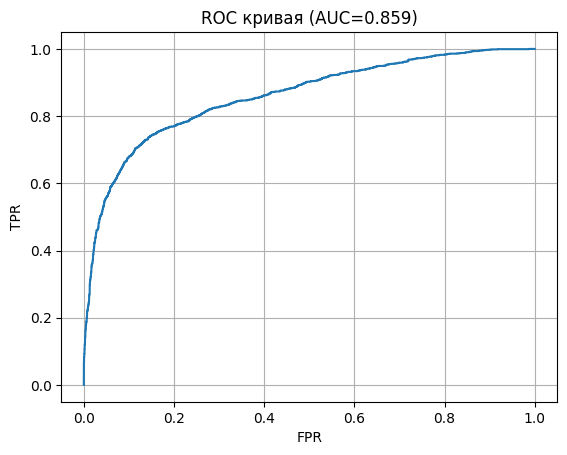

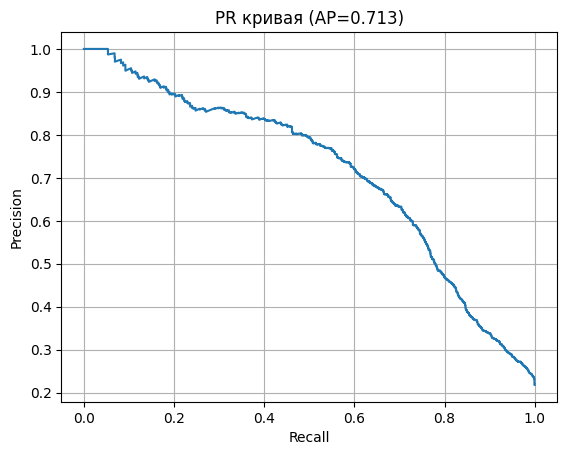

In [18]:
pipe_base.fit(X_train, Y_train)

# вероятности на test
p_test = pipe_base.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(Y_test, p_test)
roc_auc = roc_auc_score(Y_test, p_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC кривая (AUC={roc_auc:.3f})")
plt.grid(True)
plt.show()

prec, rec, _ = precision_recall_curve(Y_test, p_test)
pr_auc = average_precision_score(Y_test, p_test)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR кривая (AP={pr_auc:.3f})")
plt.grid(True)
plt.show()


## 3-4) Сравнение моделей: CatBoost / XGBoost

Цель блока — честно сравнить два сильных бустинга на одинаковом разбиении и одинаковых метриках.

Почему сравниваю именно эти модели:
- **CatBoost** умеет работать с категориальными признаками напрямую.
- **XGBoost** требует перевода категорий в числа, поэтому для него использую пайплайн с заполнением пропусков и OHE.

Как оцениваю качество:
- Использую **StratifiedKFold (5 фолдов)**, чтобы доля дефолтов была примерно одинаковой в каждом фолде.
- Метрики: **ROC-AUC** и **PR-AUC**.  
  PR-AUC важнее для кредитного скоринга, потому что класс “дефолт” встречается реже и именно его качество распознавания критично.

Результат блока — средние значения метрик по кросс-валидации для обеих моделей. По итогам выбираю модель-лидера (в первую очередь по PR-AUC) и уже её дальше тюню и фиксирую для финального теста и деплоя.

In [19]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

cat_idx = [X_train.columns.get_loc(c) for c in object_cols]

cat_boost = CatBoostClassifier(
    random_seed=1,
    verbose=False,
    allow_writing_files=False
)

def count_metric_catboost():
    roc_scores = []
    pr_scores = []
    for tr_idx, val_idx in cv.split(X_train, Y_train):
        X_tr = X_train.iloc[tr_idx]
        y_tr = Y_train[tr_idx]
        X_val = X_train.iloc[val_idx]
        y_val = Y_train[val_idx]

        model = CatBoostClassifier(
            random_seed=1,
            verbose=False,
            allow_writing_files=False
        )

        model.fit(X_tr, y_tr, cat_features=cat_idx)
        p_val = model.predict_proba(X_val)[:, 1]

        roc_scores.append(roc_auc_score(y_val, p_val))
        pr_scores.append(average_precision_score(y_val, p_val))

    return (np.mean(roc_scores), np.mean(pr_scores))

roc_mean, pr_mean = count_metric_catboost()
print(f"CatBoost ROC-AUC: {roc_mean}")
print(f"CatBoost PR-AUC: {pr_mean}")


CatBoost ROC-AUC: 0.9454483401530211
CatBoost PR-AUC: 0.9035301701394591


In [20]:
model_xg = XGBClassifier(
    random_state=1,
    eval_metric="logloss"
)

pipe_xg = Pipeline(
    steps=[
        ("transform", prepare),
        ("model", model_xg)
    ]
)

score_xg = cross_validate(pipe_xg, X_train, Y_train, cv=cv, scoring=score)

print(f"XGBoost ROC-AUC: {score_xg['test_ROC-AUC'].mean()}")
print(f"XGBoost PR-AUC: {score_xg['test_pr_auc'].mean()}")

XGBoost ROC-AUC: 0.9460948737394856
XGBoost PR-AUC: 0.9014145897254201


#### Сводка метрик

In [21]:
results = pd.DataFrame(
    [
        {"модель": "CatBoost", "ROC-AUC": roc_mean, "PR-AUC": pr_mean},
        {"модель": "XGBoost", "ROC-AUC": score_xg["test_ROC-AUC"].mean(), "PR-AUC": score_xg["test_pr_auc"].mean()},
    ]
)

display(results)

,модель,ROC-AUC,PR-AUC
0,CatBoost,0.945448,0.903530
1,XGBoost,0.946095,0.901415


In [22]:
model = CatBoostClassifier(
    random_seed=1,
    verbose=False,
    allow_writing_files=False
)
model.fit(X_train, Y_train,  cat_features=cat_idx)


p_test = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(Y_test, p_test)
pr = average_precision_score(Y_test, p_test)

print(f"ROC-AUC на тесте: {roc}")
print(f"PR-AUC на тесте: {pr}")



ROC-AUC на тесте: 0.9427771270971326
PR-AUC на тесте: 0.897714845069858


### Подбор гиперпараметров CatBoost через RandomizedSearchCV

Задача: улучшить качество модели CatBoost по PR-AUC.


- текущие параметры по умолчанию не гарантируют лучшее качество
- кроссвалидация, чтобы доля дефолтов сохранялась в каждом фолде
- после подбора фиксирую лучшие параметры и считаю метрики на тестовой выборке

In [23]:
base_model = CatBoostClassifier(
    random_seed=1,
    verbose=False,
    allow_writing_files=False
)

param_distributions = {
    "iterations": [300, 600, 900, 1200],
    "depth": [4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2],
    "l2_leaf_reg": [1, 3, 5, 7, 9, 12, 15, 20],
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="average_precision",
    cv=cv,
    refit=True,
    random_state=1,
    verbose=1
)

search.fit(X_train, Y_train, cat_features=cat_idx)

best_model = search.best_estimator_

print(f"Лучший PR-AUC на CV: {search.best_score_}")
print("Лучшие параметры:", search.best_params_)

p_test = best_model.predict_proba(X_test)[:, 1]

roc_test = roc_auc_score(Y_test, p_test)
pr_test = average_precision_score(Y_test, p_test)

print(f"ROC-AUC на тесте: {roc_test}")
print(f"PR-AUC на тесте: {pr_test}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучший PR-AUC на CV: 0.9062231351990002
Лучшие параметры: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 600, 'depth': 4}
ROC-AUC на тесте: 0.942358398214897
PR-AUC на тесте: 0.8972345819512109


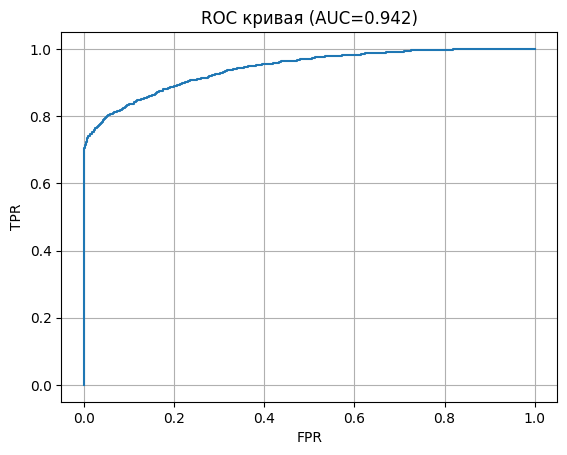

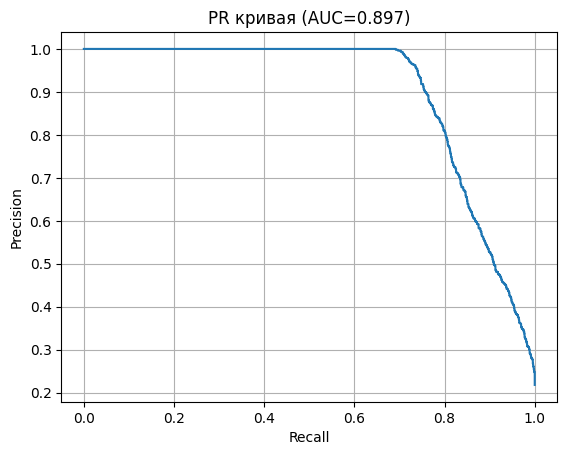

In [24]:
fpr, tpr, _ = roc_curve(Y_test, p_test)
roc = roc_auc_score(Y_test, p_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC кривая (AUC={roc:.3f})")
plt.grid(True)
plt.show()

prec, rec, _ = precision_recall_curve(Y_test, p_test)
pr = average_precision_score(Y_test, p_test)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR кривая (AUC={pr:.3f})")
plt.grid(True)
plt.show()


### Подбор порога t для вероятности дефолта

1) Получаем out of fold вероятности p_oof на обучающей выборке: для каждого объекта train вероятность считается моделью, которая не видела этот объект, чтобы честно подбирать порог, не подглядывая в test.

2) Перебираем пороги t и значения beta и находим комбинацию, которая максимизирует fb на Y_train и p_oof. При beta > 1 метрика сильнее штрафует пропущенные дефолты, то есть делает акцент на recall.

3) После выбора beta строим таблицу по всем порогам t: accuracy, precision, recall, fb и доля отказов. По этой таблице фиксируем итоговый порог

In [25]:
thresholds = np.linspace(0.05, 0.95, 19)
bet = np.arange(1.1, 2.0, 0.04)
rows = []

p_oof = np.zeros(len(X_train), dtype=float)

for tr_idx, val_idx in cv.split(X_train, Y_train):
    X_tr = X_train.iloc[tr_idx]
    y_tr = Y_train[tr_idx]
    X_val = X_train.iloc[val_idx]


    model_fold = CatBoostClassifier(
        random_seed=1,
        verbose=False,
        allow_writing_files=False,
        learning_rate =  0.1, 
        l2_leaf_reg = 1,
        iterations = 600,
        depth = 4
    )

    model_fold.fit(X_tr, y_tr, cat_features=cat_idx)
    p_oof[val_idx] = model_fold.predict_proba(X_val)[:, 1]

tmp = -1
beta = None
best_t = None

for t in thresholds:
    y_pred = (p_oof >= t).astype(int)
    for b in bet:
        metric = fbeta_score(Y_train, y_pred, beta=b, zero_division=0)
        if metric > tmp:
            tmp = metric
            beta = b
            best_t = t

for t in thresholds:
    y_pred = (p_oof >= t).astype(int)
    rows.append({
        "порог": float(t),
        "accuracy": accuracy_score(Y_train, y_pred),
        "precision": precision_score(Y_train, y_pred, zero_division=0),
        "recall": recall_score(Y_train, y_pred, zero_division=0),
        "fb": fbeta_score(Y_train, y_pred, beta=beta, zero_division=0),
        "доля отказов": y_pred.mean()
    })

table = pd.DataFrame(rows).sort_values("порог")
table

,порог,accuracy,precision,recall,fb,доля отказов
0,0.05,0.654937,0.383919,0.961484,0.572066,0.546452
1,0.10,0.826586,0.564425,0.899050,0.708884,0.347557
2,0.15,0.890825,0.709668,0.845586,0.778150,0.259987
3,0.20,0.916497,0.805643,0.813577,0.809968,0.220346
4,0.25,0.928470,0.869061,0.791418,0.824760,0.198703
5,0.30,0.933651,0.911759,0.770489,0.828580,0.184389
6,0.35,0.936452,0.941499,0.755716,0.829808,0.175141
7,0.40,0.937872,0.959133,0.747098,0.830138,0.169960
8,0.45,0.938332,0.969174,0.740943,0.829312,0.166814
9,0.50,0.938601,0.976668,0.736194,0.828498,0.164473


In [26]:
best_row = table.loc[table["fb"].idxmax()]
best_t = best_row["порог"]
best_row, best_t

(порог           0.400000
 accuracy        0.937872
 precision       0.959133
 recall          0.747098
 fb              0.830138
 доля отказов    0.169960
 Name: 7, dtype: float64,
 np.float64(0.39999999999999997))

In [27]:
best_pred = (p_test >= best_t).astype(int)

print("Порог:", best_t)
print("accuracy:", accuracy_score(Y_test, best_pred))
print("precision:", precision_score(Y_test, best_pred, zero_division=0))
print("recall:", recall_score(Y_test, best_pred, zero_division=0))
print("fb:", fbeta_score(Y_test, best_pred,beta = beta ,zero_division=0))
print("доля отказов:", best_pred.mean())

Порог: 0.39999999999999997
accuracy: 0.93584036838066
precision: 0.9613615455381784
recall: 0.7353976073187896
fb: 0.8229196731767631
доля отказов: 0.16684574059861856


In [28]:
t = round(best_t, 2)

p_test = model.predict_proba(X_test)[:, 1]
y_pred = (p_test >= t).astype(int)

print("Порог:", t)
print("accuracy:", round(accuracy_score(Y_test, y_pred), 2))
print("precision:", round(precision_score(Y_test, y_pred, zero_division=0), 2))
print("recall:", round(recall_score(Y_test, y_pred, zero_division=0), 2))
print("fb:", round(fbeta_score(Y_test, y_pred, beta = beta, zero_division=0), 2))
print("Доля предсказанных дефолтов:", round(y_pred.mean(), 3))
print("Доля реальных дефолтов:", round(np.mean(Y_test), 3))

Порог: 0.4
accuracy: 0.93
precision: 0.96
recall: 0.73
fb: 0.82
Доля предсказанных дефолтов: 0.165
Доля реальных дефолтов: 0.218


## Feature importance

Ниже приведена важность признаков по CatBoost. Она отражает вклад признака в качество модели и не является причинной интерпретацией. При коррелирующих признаках вклад может делиться между ними, поэтому порядок в топе - ориентир

Короткая интерпретация топ-признаков:
- **loan_percent_income** — доля платежа/кредита относительно дохода: чем выше нагрузка на доход, тем выше риск дефолта.
- **person_home_ownership** — статус жилья: некий показатель финансовой устойчивости.
- **person_income** — уровень дохода: базовый фактор платёжеспособности.
- **loan_grade** — внутренний рейтинг/класс кредита: агрегирует риск, поэтому закономерно высоко.
- **loan_intent** — цель кредита: разные цели имеют разный риск-профиль.

Вывод: модель в основном опирается на признаки, связанные с долговой нагрузкой и финансовой устойчивостью, что согласуется с доменной логикой кредитного риска

In [29]:
cat_model_final = CatBoostClassifier(
    random_seed=1,
    verbose=False,
    allow_writing_files=False,
    iterations=600,
    depth=4,
    learning_rate=0.1,
    l2_leaf_reg=1
)
cat_model_final.fit(X_train, Y_train, cat_features=cat_idx)

imp = cat_model_final.get_feature_importance()
feat_imp = pd.DataFrame({
    "признак": X_train.columns,
    "важность": imp
}).sort_values("важность", ascending=False)

print("Топ признаков:")
display(feat_imp.reset_index(drop=True))

Топ признаков:


,признак,важность
0,loan_percent_income,29.019452
1,person_home_ownership,19.416861
2,person_income,18.060871
3,loan_grade,11.253620
4,loan_intent,8.145255
5,person_emp_length,4.724667
6,loan_int_rate,4.460358
7,person_age,2.291818
8,loan_amnt,2.254905
9,cb_person_cred_hist_length,0.289346


## Итог

В качестве итогового порога выбран **t = 0.20** — он даёт лучший баланс ошибок по метрике **fb** (с повышенным акцентом на recall по дефолтам).

При пороге **t = 0.40** модель получается слишком строгой: она предсказывает дефолт лишь примерно для **~0.16** клиентов при реальной доле дефолтов **~0.22**, из-за чего растёт число пропущенных дефолтов  
Порог **t = 0.20** ближе к реальной доле дефолтов и повышает долю обнаруженных дефолтов, что важнее для задачи кредитного риска.

In [30]:
cat_model_final.save_model("model.cbm")
meta = {
    "threshold": 0.2,
    "features": X_train.columns.to_list(),
    "cat_cols": object_cols
}

with open("meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
